<a href="https://colab.research.google.com/github/jmparradov/EACD-03-BIGDATA/blob/master/06_%5BTALLER%5D_DataFrame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False);
from IPython.display import Image

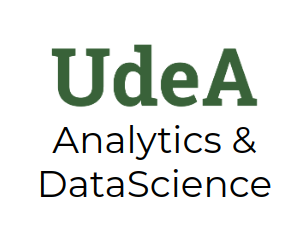

In [2]:
Image("local/imgs/udea-datascience.png")

In [3]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

In [8]:
#SparkContext
import re
import unicodedata

from pyspark.sql import SQLContext

from pyspark.sql.types import IntegerType
from pyspark.sql.functions import to_timestamp, regexp_replace, lower, when
from pyspark.sql.types import StringType

from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)


# **TALLER 2: DataFrame**
## Desarrollado por: Mg. Efraín Alberto Oviedo; Ing. Kevin Martínez Gallego
## Universidad de Antioquia

Por favor, ingrese la información de cada integrante del grupo de trabajo

**Nombre Completo:** Juan Mauricio Parrado Villa

**Cédula:** 1017206626

**Correo Institucional:** mauricio.parrado@udea.edu.co

#**Análisis de becas académicas para estudiantes Colombianos**

El ICETEX ha dispuesto un histórico de becas ofrecidas para estudios de nivel de pregrado y posgrado, presenciales o virtuales, que han sido propuestas para fortalecer la formación académica de ciudadanos colombianos en el exterior.

(Disponible en https://www.datos.gov.co/Educaci-n/Icetex-Hist-rico-de-Becas/eb6r-dfgr)

Para cada caso se reportan los siguientes datos:

* Código Convocatoria
* Nombre del Oferente: Nombre del gobierno que ofrece la beca.
* Área del Conocimiento
* Nombre del Programa
* Nombre del País
* Fecha de Recepción -mm/dd/aaaa
* Perfil del Aplicante
* Objetivo del Programa: Breve descripción del programa académico.

Se solicita de su ayuda para responder a los siguientes interrogantes:

In [31]:
df_Becas = sqlCtx.read.option("header",True).csv("local/data/icetex_becas.csv")
df_Becas.show()



+-------------------+--------------------+---------------------+--------------------+--------------------+------------------------------+--------------------+---------------------+
|Codigo Convocatoria| Nombre del Oferente|Area del Conocimiento| Nombre del programa|     Nombre del País|Fecha de Recepción -mm/dd/aaaa|Perfil del Aplicante|Objetivo del Programa|
+-------------------+--------------------+---------------------+--------------------+--------------------+------------------------------+--------------------+---------------------+
|          2127916.0|OEA - TOP - ARGEN...|       ADMINISTRACIÓN|POLÍTICAS DE GOBI...|PLATAFORMA DE EDU...|          05/27/2016 12:00:...|El programa está ...| a) Proporcionar a...|
|          3101616.0|ALIANZA DEL PACÍF...|     DIFERENTES AREAS|PLATAFORMA DE MOV...|Chile (República ...|                          null|El programa está ...| El objetivo del P...|
|          2221414.0|GOBIERNO DE LA INDIA|  INGENIERIA Y AFINES|DATA COMMUNICATIO...|India (Rep

##**A) Calidad de datos**

Revise cada una de las variables disponibles y resuelva los problemas de calidad de datos que puedan afectar el desarrollo de este taller, justificando las razones de su decisión para cada caso


Presente aquí el código desarrollado y el resultado obtenido

In [34]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])


for col in df_Becas.columns:
    # Apply the accent removal function to each header
    df_Becas = df_Becas.withColumnRenamed(col, remove_accents(col).lower().replace(" ", "_"))

df_Becas = df_Becas.withColumnRenamed("fecha_de_recepcion_-mm/dd/aaaa", "fecha_de_recepcion")

# Cast 'codigo_convocatoria' to integer
df_Becas = df_Becas.withColumn("codigo_convocatoria", df_Becas["codigo_convocatoria"].cast(IntegerType()))

# Cast 'fecha_de_recepción' to timestamp
df_Becas = df_Becas.withColumn("fecha_de_recepcion", to_timestamp("fecha_de_recepcion", "MM/dd/yyyy hh:mm:ss a"))
df_Becas.show(100)

+-------------------+--------------------+---------------------+--------------------+--------------------+-------------------+--------------------+---------------------+-------------------+
|codigo_convocatoria| nombre_del_oferente|area_del_conocimiento| nombre_del_programa|     nombre_del_pais| fecha_de_recepcion|perfil_del_aplicante|objetivo_del_programa|fecha_de_recepcion2|
+-------------------+--------------------+---------------------+--------------------+--------------------+-------------------+--------------------+---------------------+-------------------+
|            2127916|OEA - TOP - ARGEN...|       ADMINISTRACIÓN|POLÍTICAS DE GOBI...|PLATAFORMA DE EDU...|2016-05-27 00:00:00|El programa está ...| a) Proporcionar a...|2016-05-27 00:00:00|
|            3101616|ALIANZA DEL PACÍF...|     DIFERENTES AREAS|PLATAFORMA DE MOV...|Chile (República ...|               null|El programa está ...| El objetivo del P...|               null|
|            2221414|GOBIERNO DE LA INDIA|  INGENI

In [35]:
# Limpiando los datos
def remove_quotes_from_strings(df_Becas):
    for col in df_Becas.columns:
        if df_Becas.schema[col].dataType == StringType():
            df_Becas = df_Becas.withColumn(col, regexp_replace(df_Becas[col], '"', ''))
    return df_Becas

def remove_parentheses_content(text):
  return re.sub(r'\([^)]*\)', '', text)

df_Becas = remove_quotes_from_strings(df_Becas)
df_Becas = df_Becas.withColumn("nombre_del_pais", regexp_replace(df_Becas["nombre_del_pais"], r'\([^)]*\)', ''))
df_Becas = df_Becas.withColumn("nombre_del_pais", when(lower(df_Becas["nombre_del_pais"]).contains("plataforma"), "Plataforma Virtual").otherwise(df_Becas["nombre_del_pais"]))
df_Becas.show()

+-------------------+--------------------+---------------------+--------------------+------------------+-------------------+--------------------+---------------------+-------------------+
|codigo_convocatoria| nombre_del_oferente|area_del_conocimiento| nombre_del_programa|   nombre_del_pais| fecha_de_recepcion|perfil_del_aplicante|objetivo_del_programa|fecha_de_recepcion2|
+-------------------+--------------------+---------------------+--------------------+------------------+-------------------+--------------------+---------------------+-------------------+
|            2127916|OEA - TOP - ARGEN...|       ADMINISTRACIÓN|POLÍTICAS DE GOBI...|Plataforma Virtual|2016-05-27 00:00:00|El programa está ...| a) Proporcionar a...|2016-05-27 00:00:00|
|            3101616|ALIANZA DEL PACÍF...|     DIFERENTES AREAS|PLATAFORMA DE MOV...|            Chile |               null|El programa está ...| El objetivo del P...|               null|
|            2221414|GOBIERNO DE LA INDIA|  INGENIERIA Y AFI

##**B) Aumento de ofertas de becas**

Identifique si la cantidad de becas ofrecidas para ciudadanos colombianos se ha incrementado con los años

Presente aquí el código desarrollado y el resultado obtenido

In [58]:

df_Anios_Becas = spark.sql("""
    SELECT year(fecha_de_recepcion) year_convocatoria, count(*) as Becas FROM Becas
    where fecha_de_recepcion is not null
    Group by year_convocatoria
    order by year_convocatoria ASC
""")
df_Anios_Becas.show(10000, False)


+-----------------+-----+
|year_convocatoria|Becas|
+-----------------+-----+
|2011             |126  |
|2012             |135  |
|2013             |121  |
|2014             |165  |
|2015             |114  |
|2016             |177  |
+-----------------+-----+



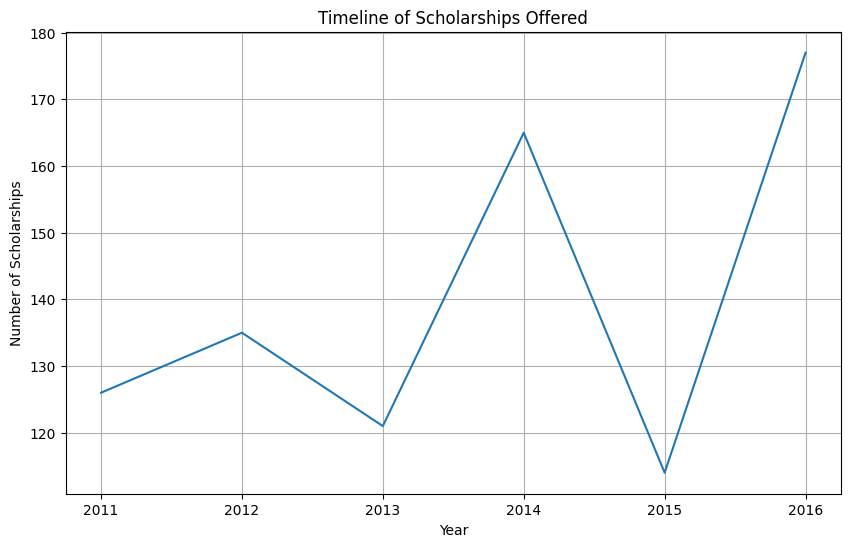

In [59]:
# prompt: plot df_Anios_Becas as timeline just one line

import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for plotting
df_Anios_Becas_pd = df_Anios_Becas.toPandas()

# Create the timeline plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(df_Anios_Becas_pd['year_convocatoria'], df_Anios_Becas_pd['Becas'])
plt.xlabel('Year')
plt.ylabel('Number of Scholarships')
plt.title('Timeline of Scholarships Offered')
plt.grid(True)
plt.show()

##**C) Paises que han ofrecido becas**

Presente un listado con todos los países (diferentes de Colombia) de los que se tiene reporte que han ofrecido becas para estudiantes colombianos (*solamente presentar nombres de países, y estos solo deben aparecer una única vez en la lista*)

Presente aquí el código desarrollado y el resultado obtenido

In [65]:
df_Anios_Becas = spark.sql("""
    SELECT nombre_del_pais FROM Becas
    where nombre_del_pais != 'Colombia'
    Group by nombre_del_pais
    order by nombre_del_pais ASC
""")
df_Anios_Becas.show(10000, False)

+-------------------------------------------------+
|nombre_del_pais                                  |
+-------------------------------------------------+
|Argentina                                        |
|Australia                                        |
|Barbados Jamaica & Trinidad y Tobago             |
|Belice                                           |
|Brasil                                           |
|Brunéi                                           |
|Bélgica                                          |
|Canadá                                           |
|Checa Rep.                                       |
|Chile                                            |
|China                                            |
|Colombia                                         |
|Corea del Sur                                    |
|Costa Rica                                       |
|Diferentes Países                                |
|Ecuador                                          |
|Egipto     

##**D) Áreas del conocimiento y Posgrados**

Se desea averiguar cúal es el área de conocimiento predominante por país. Además, queremos conocer qué porcentaje de los programas ofrecidos (**de acuerdo al nombre del programa**) corresponden a estudios de posgrado.

Presente aquí el código desarrollado y el resultado obtenido

In [72]:
spark.sql("""
          Select area_del_conocimiento, count(*) as becas From Becas
          Group by area_del_conocimiento
          Order by count(*) DESC
          """
).show(100, False)

+-----------------------------------------------+-----+
|area_del_conocimiento                          |becas|
+-----------------------------------------------+-----+
|ADMINISTRACIÓN                                 |248  |
|INGENIERIA Y AFINES                            |230  |
|DIFERENTES AREAS                               |159  |
|ADMINISTRACIÓN - ECONOMÍA                      |107  |
|CIENCIAS AGROPECUARIAS                         |95   |
|CIENCIAS DE LA EDUCACION                       |85   |
|CIENCIAS SOCIALES                              |84   |
|HUMANIDADES                                    |61   |
|MAESTRÍAS EN DIFERENTES ÁREAS                  |58   |
|POSGRADO DIFERENTES AREAS                      |45   |
|CIENCIAS NATURALES Y ECOLOGIA                  |43   |
|ADMINISTRACIÓN - INGENIERÍA Y AFINES           |29   |
|MAESTRÍAS Y DOCTORADOS EN DIFERENTES ÁREAS     |28   |
|PREGRADO EN DIFERENTES AREAS                   |27   |
|CIENCIAS NATURALES O AGROPECUARIAS             

##**E) ¿Qué podemos concluir a partir del Perfil del Aspirante y el Objetivo del Programa?**

Se dispone de dos campos de descripción, que no emplean un formato claro que permita analizar los perfiles de los aspirantes con respecto al objetivo del programa.

Plantee una forma de analizar esta información para conocer las relaciones entre los perfiles y lo objetivos.

Presente aquí el código desarrollado y el resultado obtenido

##**Análisis de los resultados**

Teniendo en cuenta los resultados obtenidos en los puntos anteriores, presente sus impresiones sobre las becas académicas disponibles para los estudiantes colombianos.


#**Notas:**

* Analice los resultados de cada punto y presente sus conclusiones
* Utilice al menos una vez cada uno de los siguientes métodos

  *   agg
  *   withColumn
  *   groupBy
  *   sql
  *   registerFunction